In [1]:
import pandas as pd
import re
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def parse_latlon(s):
    ''' Parse a string s which contains either a longitude or a latitude and convert it into Degree Minute Second vector'''
    
    if len(s.split('°')) >1:
        deg = s.split('°')[0]
        rest = s.split('°')[1].strip()
        if len(rest.split("''"))>1:
            rest = rest.split("''")[0].split("'")
            minute = rest[0]
            sec = rest[1]
            return [deg,minute,sec]
        elif len(rest.split('"'))>1:
            rest = rest.split('"')[0].split("'")
            minute = rest[0]
            sec = rest[1]
            return [float(deg),float(minute),float(sec)]
        elif len(rest.split("'"))>1:
            minute = rest.split("'")[0]
            return [float(deg),float(minute),None]
        elif len(rest) == 0:
            return [float(deg),None,None]


def dms_to_dd(data):
    ''' Converts Degree Minute Second vector into Decimal Degrees coordinates'''
    
    return pd.Series(np.nansum([data['degrees'],np.sign(data['degrees'])*data['minutes']/60.,np.sign(data['degrees'])*data['seconds']/3600],axis=0),index=['lat','lon'])

def convert(s):
    ''' Convert a coordinate string s into a pandas Series of latitude and longitude in Decimal Degrees format'''
    try:
        pat = "^,*\s*"
        p = re.compile(pat)
        if len(s.split('N'))>1:
            latstr = s.split('N')[0]
            lonstr = re.sub(p,'',s.split('N')[1])
        elif len(s.split('S'))>1:
            latstr = s.split('S')[0]
            lonstr = re.sub(p,'',s.split('S')[1])
            latstr = '-'+latstr
        else:
             return None   
        if lonstr.find('W') != -1:
            lonstr = '-'+lonstr
        lonstr = lonstr.split('E')[0]
        lonstr = lonstr.split('W')[0]

        lat = np.array(parse_latlon(latstr))
        lon = np.array(parse_latlon(lonstr))
        res = dms_to_dd(pd.DataFrame([lat,lon],columns=['degrees','minutes','seconds']).astype(float))
    except Exception as e:
        res = 'error'
        return pd.Series([res,res],index=['lat','lon'])
    return res

1. Load raw data, merge synthetic coordinates and mark seperately the synthetic coordiantes and the region level coordinates

In [3]:
data = pd.read_excel('data/raw_data.xlsx')
data.loc[~data['synthetic coordinates'].isna(),'coordinates'] = data.loc[~data['synthetic coordinates'].isna(),'synthetic coordinates']
data.loc[~data['synthetic coordinates'].isna(),'synthetic'] = True
region_data = data['remarks'].str.contains('region|Country').dropna()
data.loc[region_data[region_data].index,'region'] = True

2. Find unique site-coordinate combinations 

In [4]:
site_locations = data.loc[:,['site','coordinates']].drop_duplicates()
site_with_coords = site_locations[(~site_locations.coordinates.isna()) & (site_locations.coordinates != 0)]
site_with_coords = site_with_coords.merge(data.loc[~data['synthetic coordinates'].isna(),['synthetic','region']],left_index=True,right_index=True,how='left')

3. Convert string coordinates into latitudes and longitudes

In [5]:
site_with_coords[['lat','lon']] = site_with_coords.loc[:,'coordinates'].apply(convert)

4. Mark each coordinate type in a different color

In [6]:
site_with_coords = site_with_coords[site_with_coords.lon!='error']

acc_coords = site_with_coords.loc[site_with_coords.synthetic.isna()]
syn_coords = site_with_coords.loc[~site_with_coords.synthetic.isna()]
region_coords = site_with_coords.loc[~site_with_coords.region.isna()]

5. Plot results

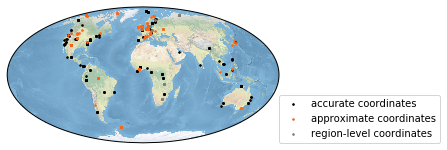

In [7]:
fig = plt.figure(figsize=(5,2.5))
ax = plt.axes(projection=ccrs.Mollweide())
ax.stock_img()
plt.scatter(acc_coords.lon.values, acc_coords.lat.values,
         color='k', marker='.', s=10,
         transform=ccrs.Geodetic(),label = 'accurate coordinates'
         )

plt.scatter(syn_coords.lon.values, syn_coords.lat.values,
         color='#ff6512', marker='.', s=10,
         transform=ccrs.Geodetic(),label = 'approximate coordinates'
         )

plt.scatter(region_coords.lon.values, region_coords.lat.values,
         color='grey', marker='.', s=10,
         transform=ccrs.Geodetic(),label = 'region-level coordinates'
         )
plt.legend(loc=(1,0))
#plt.savefig('results/fig1.svg',dpi=600)


plt.show()


6. Count number of distinct locations and sites

In [10]:
print('Total number of locations is %d' % site_with_coords[['lat','lon']].drop_duplicates().shape[0])
print('Total number of sites is %d' % data[~data.units.str.contains('trap')].site.nunique())

Total number of locations is 170
Total number of sites is 537


In [322]:
data.groupby('units').site.nunique()

units
individuals/kg           47
individuals/m^2         322
individuals/plant         3
individuals/trap         11
mg/m^2 (dry weight)     267
mg/m^2 (wet weight)      65
mg/trap (dry weight)     62
Name: site, dtype: int64

In [7]:
#data.groupby('standard groups').site.nunique()
metadata = pd.read_csv('data/groups_per_reference.csv')
data_meta = data.merge(metadata,left_on='reference', right_on='Paper',how='left')

In [34]:
data_meta.loc[data_meta['sub-class']=='Acari','aggregated taxon'] = 'Acari'
data_meta.loc[data_meta['sub-class']=='Collembola','aggregated taxon'] = 'Collembola'
data_meta.loc[data_meta['super-family']=='Isoptera','aggregated taxon'] = 'Isoptera'
data_meta.loc[data_meta['family']=='Formicidae','aggregated taxon'] = 'Formicidae'
data_meta.loc[data_meta['aggregated taxon'].isna(),'aggregated taxon'] = 'Other'

In [38]:
data_meta.groupby('aggregated environment').site.nunique()

aggregated environment
above ground    118
plants          137
soil/litter     359
Name: site, dtype: int64

In [37]:
data_meta.groupby('aggregated taxon').site.nunique()

aggregated taxon
Acari         195
Collembola    203
Formicidae    159
Isoptera       73
Other         379
Name: site, dtype: int64